In [254]:
from flair.models import SequenceTagger
from flair.data import Sentence
import re
import pandas as pd
import stanza
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import yake
import pylab
import itertools
import graphviz
import numpy as np

In [2]:
pos = SequenceTagger.load('bert-base-turkish-cased-pos/final-model.pt')

2022-06-06 23:23:59,651 loading file bert-base-turkish-cased-pos/final-model.pt
2022-06-06 23:24:03,744 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, VERB, PUNCT, ADJ, ADV, PROPN, CCONJ, DET, PRON, ADP, NUM, AUX, INTJ, X, SCONJ, SYM, PART


In [3]:
dependency = SequenceTagger.load('bert-base-turkish-cased-dependency/final-model.pt')

2022-06-06 23:24:05,516 loading file bert-base-turkish-cased-dependency/final-model.pt
2022-06-06 23:24:09,107 SequenceTagger predicts: Dictionary with 42 tags: <unk>, punct, obl, nmod:poss, root, nsubj, amod, obj, conj, advmod, det, acl, case, cc, advcl, compound, flat, nmod, advmod:emph, nummod, ccomp, compound:lvc, cop, csubj, compound:redup, discourse, aux:q, parataxis, aux, mark, iobj, cc:preconj, appos, clf, xcomp, vocative, list, orphan, dislocated, fixed, dep, goeswith


In [4]:
stanza.download('tr')

2022-06-06 23:24:12 INFO: Downloading default packages for language: tr (Turkish)...
2022-06-06 23:24:12 INFO: File exists: /Users/hamza.akyildiz/stanza_resources/tr/default.zip.
2022-06-06 23:24:13 INFO: Finished downloading models and saved to /Users/hamza.akyildiz/stanza_resources.


In [5]:
nlp_raw = stanza.Pipeline(lang='tr')
nlp = stanza.Pipeline(lang='tr',tokenize_pretokenized=True)

2022-06-06 23:24:18 INFO: Loading these models for language: tr (Turkish):
| Processor | Package |
-----------------------
| tokenize  | imst    |
| mwt       | imst    |
| pos       | imst    |
| lemma     | imst    |
| depparse  | imst    |

2022-06-06 23:24:18 INFO: Use device: cpu
2022-06-06 23:24:18 INFO: Loading: tokenize
2022-06-06 23:24:18 INFO: Loading: mwt
2022-06-06 23:24:18 INFO: Loading: pos
2022-06-06 23:24:18 INFO: Loading: lemma
2022-06-06 23:24:18 INFO: Loading: depparse
2022-06-06 23:24:18 INFO: Done loading processors!
2022-06-06 23:24:18 INFO: Loading these models for language: tr (Turkish):
| Processor | Package |
-----------------------
| tokenize  | imst    |
| mwt       | imst    |
| pos       | imst    |
| lemma     | imst    |
| depparse  | imst    |

2022-06-06 23:24:18 INFO: Use device: cpu
2022-06-06 23:24:18 INFO: Loading: tokenize
2022-06-06 23:24:18 INFO: Loading: mwt
2022-06-06 23:24:18 INFO: Loading: pos
2022-06-06 23:24:19 INFO: Loading: lemma
2022-06

In [6]:
f = open('simplified-input.txt', 'r')
text = f.read()

In [7]:
text = text.replace("'",'')
text = text.replace("/",'')
text = text.replace("-",'')
text = text.replace("-",'')
text = text.replace("’",'')

In [8]:
sentences = nlp_raw(text).sentences

/Users/hamza.akyildiz/Library/Python/3.8/lib/python/site-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


In [9]:
tokenized_sentences = []
for sentence in sentences:
    s = Sentence(sentence.text)
    tokenized_sentence = []
    for i in s:
        u = re.findall(r'"(.*?)"', str(i))
        tokenized_sentence.append(u[0])
    tokenized_sentences.append(tokenized_sentence)

In [10]:
doc = nlp(tokenized_sentences)

In [11]:
fiilimsi_affixes=["ma","me","mak","mek","ış","iş","uş","üş", #isim-fiil
                 "an","en","mış","miş","müş","muş","ası","esi","maz","mez","ar","er","ır","ir","r",
                  "dık","dik","duk","dük","acak","ecek",
                 "ken","alı","eli","madan","meden","ince","ip","arak","dıkça","e","casına","maksızın","dığında"]

In [12]:
def detect_fiilimsi(doc):
    for sentence in doc.sentences:
        s1 = Sentence(sentence.text)
        s2 = Sentence(sentence.text)
        dependency.predict(s1)
        pos.predict(s2)
        for i,word in enumerate(sentence.words):
            word.deprel = s1.to_dict()['all labels'][i]['value']
            word.upos = s2.to_dict()['all labels'][i]['value']
            if(word.upos == "VERB" and word.deprel != 'root'):
                affix = word.text[len(word.lemma):]
                for i in fiilimsi_affixes:
                    if i in affix:
                        word.misc = 'fiilimsi'

In [13]:
detect_fiilimsi(doc)

In [16]:
def get_noun_phrases(sentences):
    noun_phrases = []
    for sentence_no,sentence in enumerate(sentences):
        for word_no,word in enumerate(sentence.words):
                next_word_head = sentence.words[word.head-1]
                next_word = sentence.words[word.id] if word.id < len(sentence.words) else sentence.words[word.id-1]
                if word.upos == 'NOUN' and word.deprel == 'nmod:poss' and next_word_head.upos == 'NOUN':
                    noun_phrase = {'text':' '.join([word.text,next_word_head.text]),
                                   'lemma':' '.join([word.lemma,next_word_head.lemma]),
                                  'sentence_id':sentence_no}
                    noun_phrases.append(noun_phrase)
                elif word.upos == 'NUM' and word.deprel == 'nummod' and next_word_head.upos == 'NOUN':
                    noun_phrase = {'text':' '.join([word.text,next_word_head.text]),
                                   'lemma':' '.join([word.lemma,next_word_head.lemma]),
                                  'sentence_id':sentence_no}
                    #noun_phrases.append(noun_phrase)
                elif word.upos == 'ADJ' and word.deprel == 'amod' and next_word_head.upos == 'NOUN':
                    noun_phrase = {'text':' '.join([word.text,next_word_head.text]),
                                   'lemma':' '.join([word.lemma,next_word_head.lemma]),
                                  'sentence_id':sentence_no}
                    noun_phrases.append(noun_phrase)
                elif word.upos == 'NOUN' and word.deprel in ['nsubj']:
                    noun_phrase = {'text':word.text,
                                   'lemma':word.lemma,
                                  'sentence_id':sentence_no}
                    noun_phrases.append(noun_phrase)
                elif word.upos == 'VERB' and word.misc in ['fiilimsi'] and word.deprel == 'nmod:poss' and next_word_head.upos == 'NOUN':
                    noun_phrase = {'text':' '.join([word.text,next_word_head.text]),
                                   'lemma':' '.join([word.lemma,next_word_head.lemma]),
                                  'sentence_id':sentence_no}
                    noun_phrases.append(noun_phrase)
    return noun_phrases

In [17]:
noun_phrases = get_noun_phrases(doc.sentences)
common_noun_phrases = Counter([d['lemma'] for d in noun_phrases]).most_common()

In [18]:
df = pd.DataFrame.from_records(noun_phrases)

In [20]:
df.head()

,text,lemma,sentence_id
0,kampüsü,kampü,0
1,zamanlı üyesi,zamanlı üye,2
2,öğretim üyesi,öğretim üye,2
3,üyesi,üye,2
4,öğretim görevlisi,öğretim görevli,2


# TF-IDF KW SCORING

In [22]:
stopwords_tr = set(stopwords.words('turkish'))

In [23]:
all_lemmas = []
for sentence in doc.sentences:
    for word in sentence.words:
        all_lemmas.append(word.lemma)
corpus = ' '.join(all_lemmas)

In [26]:
vectorizer = TfidfVectorizer(stop_words=stopwords_tr)
X = vectorizer.fit_transform([corpus])
kw = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).T

In [30]:
tf_idf_scores = dict(kw.reset_index().values)

In [32]:
df['lemma'] = df['lemma'].str.split(' ')

In [33]:
df['tf-idf'] = df.lemma.apply(lambda lemmas:sum(filter(lambda element:element,map(scores.get,lemmas)))/len(lemmas))

In [35]:
df['tf-idf'] = df['tf-idf']/df['tf-idf'].max()

In [39]:
df['lemma'] = df['lemma'].apply(lambda l:' '.join(l))

# FREQUENCY SCORING

In [55]:
def frequency_ranking(df):
    df['occurunces'] = df.groupby('lemma').transform(len)['text']
    df['frequency'] = df['occurunces']/df['occurunces'].max()
    return df.drop(columns=['occurunces'])

In [58]:
df = frequency_ranking(df.copy())

# YAKE SCORING

In [64]:
f = open('simplified-input.txt', 'r')
text = f.read()
text = text.replace("\n",'')

In [66]:
def yake_ranking(text, noun_phrases):
    language = "tr"
    max_ngram_size = 2
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 100

    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    
    yake_keywords=[]
    for kw in keywords:
        if kw[0] in list(noun_phrases['text']):
            yake_keywords.append(kw)
            
    yake_ranks=pd.DataFrame(yake_keywords,columns=['text','point']).merge(noun_phrases[['text','lemma']]).drop_duplicates().groupby('lemma').min('point')
    yake_ranks['point']=yake_ranks['point']/yake_ranks['point'].max()
    yake_ranks['point']=1-yake_ranks['point']
    yake_ranks['point']=yake_ranks['point']/yake_ranks['point'].max()
    return yake_ranks.sort_values('point',ascending=False).rename(columns={'point':'yake_points'})

In [68]:
yake_scores = yake_ranking(text,df)

In [78]:
df = df.groupby('lemma').max('tf-idf')

In [87]:
df = pd.concat([df,yake_scores],axis=1).fillna(0).drop('sentence_id',axis=1).reset_index()

In [95]:
df['score'] = df.sum(axis=1)
df.sort_values('score',ascending=False).head(5)

,tf-idf,frequency,yake_points,score
lemma,,,,
öğrenci,1.000000,1.0000,1.000000,3.000000
kayıt iş,0.285714,0.3125,0.952058,1.550272
elektronik dilekçe,0.185714,0.3125,0.871787,1.370001
iş,0.171429,0.1875,0.806881,1.165809
tarih,0.142857,0.1250,0.852641,1.120498


# PHRASE RELATIONS

In [96]:
def get_point(phrase1,phrase2):
    count = 0
    for sentence in doc.sentences:
        current_sentence = []
        for word in sentence.words:
            current_sentence.append(word.lemma)
        current_sentence = ' '.join(current_sentence)
        if phrase1 in current_sentence and phrase2 in current_sentence:
            count += 1
    return count

In [122]:
lemmas = df['lemma'].unique()

In [126]:
ph_pairs = pd.DataFrame(itertools.combinations(lemmas,r=2))

In [128]:
ph_pairs.columns = ['l1','l2']

In [129]:
ph_pairs['score'] = ph_pairs.apply(lambda row:get_point(row['l1'],row['l2']),axis=1)

In [135]:
lemma_scores = dict(df[['lemma','score']].values)

In [138]:
ph_pairs['l1_score'] = list(map(lemma_scores.get,ph_pairs.l1))
ph_pairs['l2_score'] = list(map(lemma_scores.get,ph_pairs.l2))

# Word Grouping

In [155]:
df['len'] = df.lemma.apply(lambda ph:len(ph.split(' ')))

In [157]:
one_word_phrases = set(df[df.len==1].lemma.unique().tolist())

In [162]:
df['group'] = df.lemma.apply(lambda l: next(iter(list(set(l.split(' ')).intersection(one_word_phrases))), None))

In [169]:
df['members'] = df.apply(lambda r:[{'key':r['lemma'],'value':r['score']}],axis=1)

In [192]:
temp = df.groupby('group')[['members']].sum()

In [193]:
temp['rep'] = temp.members.apply(lambda lst:max(lst, key=lambda x:x['value']))

In [194]:
temp['key'] = list(map(lambda e:e['key'],temp['rep']))
temp['value'] = list(map(lambda e:e['value'],temp['rep']))

In [197]:
temp.head(5)

,members,rep,key,value,group_size
group,,,,,
başvuru,"[{'key': 'başvuru', 'value': 0.119642857142857...","{'key': 'başvuru', 'value': 0.11964285714285713}",başvuru,0.119643,2
belge,"[{'key': 'belge', 'value': 0.11964285714285713}]","{'key': 'belge', 'value': 0.11964285714285713}",belge,0.119643,1
bilgi,"[{'key': 'bilgi', 'value': 0.4625091945214297}...","{'key': 'bilgi', 'value': 0.4625091945214297}",bilgi,0.462509,7
bölüm,"[{'key': 'bölüm', 'value': 0.11964285714285713}]","{'key': 'bölüm', 'value': 0.11964285714285713}",bölüm,0.119643,1
danışman,"[{'key': 'akademik danışman', 'value': 0.33928...","{'key': 'danışman', 'value': 1.072295842780032}",danışman,1.072296,3


In [234]:
concept_scores = dict(temp[['key','value']].values)

In [205]:
similarities = []
for i in concept_scores.keys():
    similar = [j for j in concept_scores.keys() if (i in j or j in i) and i!=j]
    similarities.append({'key':i,'values':similar})

In [207]:
for i in similarities:
    for j in similarities:
        si = set(i['values'])
        sj = set(j['values'])
        if sj.intersection(si):
            i['values'] = list(sj.union(si))
            j['values'] = list(sj.union(si))

In [209]:
for i,s in enumerate(similarities):
    key_point = concept_scores[s['key']]
    if [j for j in s['values'] if concept_scores[j]>key_point]:
        similarities.pop(i)

In [233]:
groups = [i['key'] for i in similarities]

In [212]:
temp['final_group'] = temp.apply(lambda r:r['key'] if r['key'] in groups else [i for i in groups if i in r['key'] or r['key'] in i][0],axis=1)

In [223]:
final = temp[['final_group','members']].reset_index().copy()

In [224]:
final['values'] = list(map(concept_scores.get,final['final_group']))

In [225]:
final = final.groupby('final_group').agg({'values':'mean','members':'sum'}).reset_index()

In [227]:
final['members'] = final['members'].apply(lambda r:[x for i, x in enumerate(r) if i == r.index(x)])
final['members_size'] = final.members.apply(len)

In [231]:
final['members'] = final['members'].apply(lambda l:sorted(l, key=lambda d: d['value'],reverse=True) )

In [235]:
final.head(5)

,final_group,values,members,members_size
0,başvuru,0.119643,"[{'key': 'başvuru', 'value': 0.119642857142857...",2
1,belge,0.119643,"[{'key': 'belge', 'value': 0.11964285714285713}]",1
2,bilgi,0.462509,"[{'key': 'bilgi', 'value': 0.4625091945214297}...",7
3,bölüm,0.119643,"[{'key': 'bölüm', 'value': 0.11964285714285713}]",1
4,danışman,1.072296,"[{'key': 'danışman', 'value': 1.07229584278003...",3


# Found group representatives are matched with pairs

In [232]:
def find_group(kw):
    if len(final[final.final_group == kw])>0:
        return kw
    else:
        for i in final.final_group.tolist():
            if kw in i or i in kw:
                return i

In [237]:
ph_pairs['l1_group'] = ph_pairs['l1'].apply(find_group)
ph_pairs['l2_group'] = ph_pairs['l2'].apply(find_group)

In [434]:
def get_info(kw):
    global used_attributes
    relation_th = 0.5
    cut_th = 0.2
    relations = []
    attributes = []
    temp = ph_pairs[ph_pairs.l1_group==kw]
    _max = np.percentile(temp.score,50)
    if (len(temp[temp.score>max([_max,2])]) > 2) and (concept_scores[kw]>relation_th):
        relations = temp[temp.l2_score > relation_th].l2_group.dropna().unique().tolist()
        attributes = temp[((temp.l2_score <= relation_th ) &  (temp.l2_score > cut_th))][['l2','l2_score']].drop_duplicates().to_records(index=False).tolist()
        attributes = (attributes +
            temp[temp.l1_group==temp.l2_group][['l2','l2_score']].drop_duplicates().to_records(index=False).tolist())
        attributes = sorted(attributes, key=lambda d: d[1],reverse=True) 
        attributes = list(filter(lambda e:e[1]>concept_scores[kw]/5,attributes))
        attributes = list(filter(lambda e:e[0] not in used_attributes,attributes))
        attributes = attributes[:5]
        attributes = list(map(lambda e:e[0],attributes))
        used_attributes = used_attributes + attributes
        return relations,attributes
    return [],[]

In [435]:
used_attributes = []
final[['relations','attributes']] = final.apply(lambda r:get_info(r['final_group']),axis=1,result_type='expand')

In [436]:
final['attributes'] = final.apply(lambda l:[i for i in l['attributes'] if i!=l['final_group']],axis=1)

# Visualization

In [437]:
relations_temp = final.apply(lambda r:[(r['final_group'],i) for i in r['relations']],axis=1).sum()

In [438]:
relations = []
for i in relations_temp:
    if i[0] != i[1]:
        relations.append({i[0], i[1]})

In [439]:
relations = [x for i, x in enumerate(relations) if i == relations.index(x)]

In [440]:
relations = [tuple(i) for i in relations]

In [441]:
concepts = final[['final_group','attributes']].rename(columns={'final_group':'concept'}).to_dict(orient='records')

In [442]:
def create_concept(c_dict):
    concept_attributes=""
    concept_attributes+=c_dict['concept']
    for attribute in c_dict['attributes']:
        concept_attributes+= '\n- ' + attribute
    return concept_attributes

In [443]:
def create_concept_node(concepts):
    for concept in concepts:
        concept_str=create_concept(concept)
        diagram.node(concept['concept'], concept_str,shape='box')

In [444]:
def create_relations(relations):
    for relation in relations:
        diagram.edge(relation[0],relation[1])

In [445]:
diagram = graphviz.Graph('G', filename='process.gv', engine='dot')

In [446]:
create_concept_node(concepts)

create_relations(relations)

In [447]:
concepts

[{'concept': 'başvuru', 'attributes': []},
 {'concept': 'belge', 'attributes': []},
 {'concept': 'bilgi', 'attributes': []},
 {'concept': 'bölüm', 'attributes': []},
 {'concept': 'danışman',
  'attributes': ['öğrenci danışman', 'dönem', 'bilgi', 'ders kayıt']},
 {'concept': 'ders',
  'attributes': ['ders liste',
   'ders program',
   'ders şube',
   'şube ders',
   'ders şube']},
 {'concept': 'doküman', 'attributes': []},
 {'concept': 'dönem', 'attributes': []},
 {'concept': 'elektronik dilekçe',
  'attributes': ['not', 'öğretim eleman', 'program', 'tarih bilgi']},
 {'concept': 'eğ', 'attributes': []},
 {'concept': 'eğitmen taraf', 'attributes': []},
 {'concept': 'görevli', 'attributes': []},
 {'concept': 'harf not', 'attributes': []},
 {'concept': 'içerik', 'attributes': []},
 {'concept': 'kampü', 'attributes': []},
 {'concept': 'kayıt iş', 'attributes': []},
 {'concept': 'kota', 'attributes': []},
 {'concept': 'kullanıcı', 'attributes': []},
 {'concept': 'program', 'attributes': []},

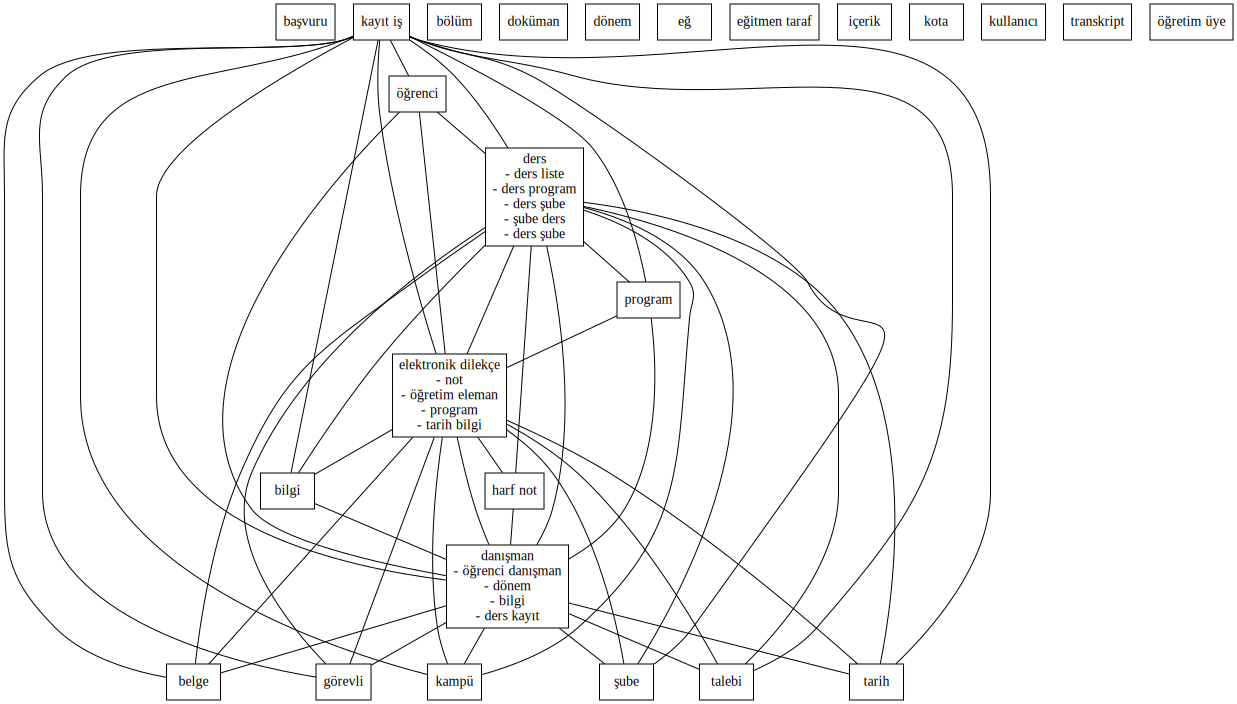

In [448]:
diagram

In [449]:
filename = diagram.render(filename='diagram')

pylab.savefig('diagram.png')

<Figure size 432x288 with 0 Axes>